In [1]:
# Para conocer el enunciado del problema, consultar el libro:
# Metodos Numericos Aplicados a la Ingeniería: Casos de estudio utilizando MATLAB (2014)
# por Héctor Jorquera y Claudio Gelmi
# 
# Código Python escrito por Claudio Gelmi, Ph.D.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import minimize

In [3]:
# Parámetros para ambas funciones
T0 = 373.15       # K
h = 10            # W/m^2*K
Ta = 273.15 + 10  # K
k = [382, 14.9, 204, 62.3]  # [1=cobre, 2=acero, 3=aluminio, 4=fierro]

# Modelo de la aleta con cambio de variable
def modelo(r, z, k):
    B = 0.001  # m
    dz1 = z[1]
    dz2 = -1/r*z[1] + 2*h/(B*k)*(z[0] - Ta)
    dz3 = 4*np.pi*r*h*(z[0] - Ta)
    return [dz1, dz2, dz3]

# Modelo que integra el modelo de la aleta y entrega fcosto, la cual representa la condición
# de borde en el extremo r = R1, para los 4 materiales: conducción igual a convección
def aleta(param, k):
    r = (0.01,0.1)
    rvalues = np.linspace(0.01,0.1,100)
    T1 = solve_ivp(modelo, r, [T0, param[0], 0], args=(k[0],), t_eval=rvalues).y
    T2 = solve_ivp(modelo, r, [T0, param[1], 0], args=(k[1],), t_eval=rvalues).y
    T3 = solve_ivp(modelo, r, [T0, param[2], 0], args=(k[2],), t_eval=rvalues).y
    T4 = solve_ivp(modelo, r, [T0, param[3], 0], args=(k[3],), t_eval=rvalues).y

    fcosto = 1000*((k[0]*T1[1,-1]+h*(T1[0,-1]-Ta))**2 + (k[1]*T2[1,-1]+h*(T2[0,-1]-Ta))**2 \
        + (k[2]*T3[1,-1] + h*(T3[0,-1]-Ta))**2 + (k[3]*T4[1,-1] + h*(T4[0,-1]-Ta))**2)
    return fcosto

In [4]:
# Rutina de optimización
# Para que se cumpla conducción = convección al final de la aleta, debemos encontrar "param" óptimo
initial_guess = [-1000]*4
result = minimize(aleta, initial_guess, args=(k,), method='Powell', tol=1e-9)
print(result)
params_opt = result.x
print(f'\nCondiciones iniciales optimizadas: {np.round(params_opt,2)}')
print(f'Función de costo evaluada en el óptimo: {np.round(result.fun,8)}')

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 5.588367372779668e-17
       x: [-1.669e+03 -6.694e+03 -2.507e+03 -4.325e+03]
     nit: 3
   direc: [[ 1.000e+00  0.000e+00  0.000e+00  0.000e+00]
           [ 0.000e+00  1.000e+00  0.000e+00  0.000e+00]
           [ 0.000e+00  0.000e+00  1.000e+00  0.000e+00]
           [ 0.000e+00  0.000e+00  0.000e+00  1.000e+00]]
    nfev: 118

Condiciones iniciales optimizadas: [-1669.   -6694.1  -2506.51 -4325.4 ]
Función de costo evaluada en el óptimo: 0.0


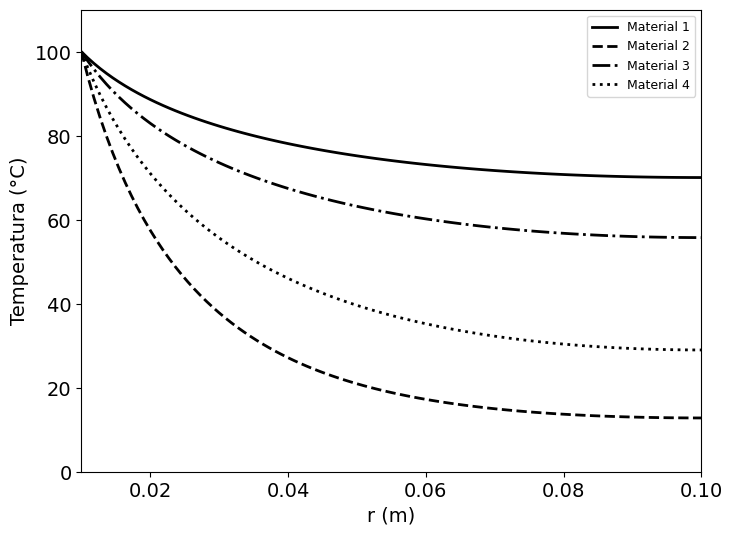

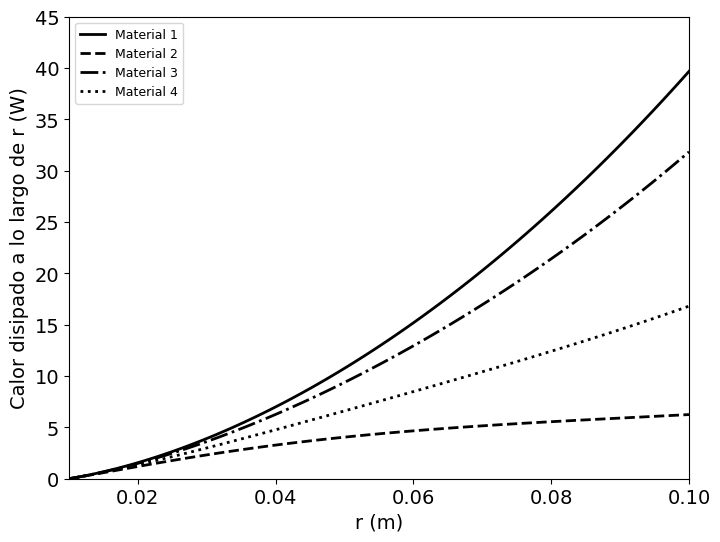

In [5]:
# Graficamos las temperaturas y pérdidas totales de calor para los 4 casos
# Configuramos diferentes estilos de línea
line_styles = ['-', '--', '-.', ':']

# Rangos integración
r = (0.01, 0.1)
rvalues = np.linspace(0.01, 0.1, 100)

for i in range(4):
    T = solve_ivp(modelo, r, [T0, params_opt[i], 0], args=(k[i],), t_eval=rvalues).y
    
    # Temperatura
    plt.figure(1, figsize=(8,6))
    plt.plot(rvalues, T[0] - 273.15, color='k', label=f'Material {i+1}', linestyle=line_styles[i], lw=2)
    plt.xlabel('r (m)', fontsize=14)
    plt.xlim(0.01,0.1)
    plt.ylabel('Temperatura (°C)', fontsize=14)
    plt.ylim(0,110)
    plt.legend(loc='best', fontsize=9)
    plt.tick_params(axis='both', labelsize=14)

    # Calor disipado
    plt.figure(2, figsize=(8,6))
    plt.plot(rvalues, T[2], color='k', label=f'Material {i+1}', linestyle=line_styles[i], lw=2)
    plt.xlabel('r (m)', fontsize=14)
    plt.xlim(0.01,0.1)
    plt.ylabel('Calor disipado a lo largo de r (W)', fontsize=14)
    plt.ylim(0, 45)
    plt.legend(loc='best', fontsize=9)
    plt.tick_params(axis='both', labelsize=14)
    
plt.show()